In [1]:
import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats
import seaborn as sn
import pickle

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

sn.set(rc={'figure.figsize':(23.4,16.54)})

In [2]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [3]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [5]:
metrics =  [
    'Monotonicity Nguyen',
    'Local Lipschitz Estimate',
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Avg-Sensitivity',
    'Random Logit',
    'Max-Sensitivity',
    'Sparseness', 
    'EffectiveComplexity',
    'Monotonicity Arya',
    'Complexity',
    'Pixel-Flipping',
    'Selectivity',
    'Model Parameter Randomisation'
]
                # ['SensitivityN': problem with implementation,
                #'Region Perturbation' seems to be same as region perturbation, 
                #'Continuity Test': Difficult to aggregate result, the paper just plot it
                #'Completeness' always returns False]
                # Nonsentitivity is removed

metrics_with_different_baselines = {
    'Faithfulness Estimate',
    'Faithfulness Correlation',
    'Monotonicity Arya',
    'Monotonicity Nguyen',
    'Pixel-Flipping',
    'Selectivity',
}
                
baselines = [
    'baseline_black',
    'baseline_mean',
    'baseline_random',
    'baseline_uniform',
    'baseline_white'
]

transform = {
    'Monotonicity Nguyen': lambda x: x,
    'Local Lipschitz Estimate': lambda x: -x, 
    'Faithfulness Estimate': abs,
    'Faithfulness Correlation': abs, 
    'Avg-Sensitivity': lambda x: -x,
    'Random Logit': lambda x: x,
    'Sparseness': lambda x: x,
    'EffectiveComplexity': lambda x: -x,
    'Nonsensitivity': lambda x: -x,
    'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
    'Max-Sensitivity': lambda x: -x,
    'Complexity': lambda x: -x, 
    "Selectivity": lambda x: -parser_method_dict(x),
    'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
    'Monotonicity Arya': lambda x: x,
}

methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam',
           'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]

model = "resnet50"
dataset = "imagenet"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

for metr in metrics:
    if metr in metrics_with_different_baselines:
        for baseline in baselines:
            data_nemenyi = pd.DataFrame()
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            for meth in methods:
                csv_name = f"csv/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data_nemenyi[meth] = transform[metr](df).values.flatten()    
            ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
            average_ranks = np.mean(ranks, axis=0)
            dico_ranks[metr_with_baseline] = average_ranks #/len(metrics)
    elif metr == 'Model Parameter Randomisation':
        for baseline in ['bottom_up','top_down']:
            data_nemenyi = pd.DataFrame()
            metr_with_baseline = f'{metr} with {baseline}'
            print(f"-- Metric: {metr_with_baseline}")
            for meth in methods:
                csv_name = f"csv/{meth}_{model}_{dataset}_{metr}_{baseline}.csv"
                df = pd.read_csv(csv_name, header = None)
                data_nemenyi[meth] = transform[metr](df).values.flatten()    
            ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
            average_ranks = np.mean(ranks, axis=0)
            dico_ranks[metr_with_baseline] = average_ranks #/len(metrics)
    else:
        data_nemenyi = pd.DataFrame()
        print(f"-- Metric: {metr}")
        for meth in methods:
            csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
            df = pd.read_csv(csv_name, header = None)
            data_nemenyi[meth] = transform[metr](df).values.flatten()    
        ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
        average_ranks = np.mean(ranks, axis=0)
        dico_ranks[metr] = average_ranks/len(metrics)

df_ranks = pd.DataFrame(dico_ranks, index= methods)
metrics_with_baselines = sorted(dico_ranks.keys())

-- Metric: Monotonicity Nguyen with baseline_black
-- Metric: Monotonicity Nguyen with baseline_mean
-- Metric: Monotonicity Nguyen with baseline_random
-- Metric: Monotonicity Nguyen with baseline_uniform
-- Metric: Monotonicity Nguyen with baseline_white
-- Metric: Local Lipschitz Estimate
-- Metric: Faithfulness Estimate with baseline_black
-- Metric: Faithfulness Estimate with baseline_mean
-- Metric: Faithfulness Estimate with baseline_random
-- Metric: Faithfulness Estimate with baseline_uniform
-- Metric: Faithfulness Estimate with baseline_white
-- Metric: Faithfulness Correlation with baseline_black
-- Metric: Faithfulness Correlation with baseline_mean
-- Metric: Faithfulness Correlation with baseline_random
-- Metric: Faithfulness Correlation with baseline_uniform
-- Metric: Faithfulness Correlation with baseline_white
-- Metric: Avg-Sensitivity
-- Metric: Random Logit
-- Metric: Max-Sensitivity
-- Metric: Sparseness
-- Metric: EffectiveComplexity
-- Metric: Monotonicity Ary

In [6]:
df_ranks

,Monotonicity Nguyen with baseline_black,Monotonicity Nguyen with baseline_mean,Monotonicity Nguyen with baseline_random,Monotonicity Nguyen with baseline_uniform,Monotonicity Nguyen with baseline_white,Local Lipschitz Estimate,Faithfulness Estimate with baseline_black,Faithfulness Estimate with baseline_mean,Faithfulness Estimate with baseline_random,Faithfulness Estimate with baseline_uniform,...,Pixel-Flipping with baseline_random,Pixel-Flipping with baseline_uniform,Pixel-Flipping with baseline_white,Selectivity with baseline_black,Selectivity with baseline_mean,Selectivity with baseline_random,Selectivity with baseline_uniform,Selectivity with baseline_white,Model Parameter Randomisation with bottom_up,Model Parameter Randomisation with top_down
integratedgrad,6.5780,4.7705,4.4925,5.5655,6.2190,0.130857,6.7640,2.8740,3.2395,5.6935,...,1.9230,4.0050,3.7955,4.0605,4.7495,4.7590,4.5450,4.2115,9.1335,9.1080
smoothgrad,4.9140,4.7215,4.8360,4.6105,4.7800,0.262536,5.1420,5.1875,5.3035,5.0350,...,6.1890,5.9480,5.4015,5.2280,5.3710,5.3605,5.2385,5.2505,2.0080,1.9765
guidedbackprop,6.7385,6.7965,6.8300,7.1455,6.4915,0.107214,7.8930,7.9925,8.0920,8.7440,...,7.4240,7.1195,4.4145,5.0745,5.5785,5.4295,5.3330,5.1930,9.6280,9.5465
rise,6.1545,6.5910,6.7560,6.6190,6.4680,0.673964,5.0330,5.5120,5.5650,5.2175,...,5.8115,5.4320,6.2335,5.5590,5.6505,5.6440,5.6100,5.6380,5.8420,5.8740
gradcam,4.4895,4.8290,4.7335,4.2315,4.5585,0.446750,4.6880,5.4400,5.3435,4.8140,...,5.6995,5.3530,7.2080,7.5160,7.0430,7.0310,7.1665,7.4085,5.3700,5.3350
scorecam,4.6750,4.7810,4.8320,4.3900,4.7285,0.498964,5.0495,5.6645,5.5230,5.0075,...,5.9370,5.7105,7.3425,7.4160,6.9500,7.0035,7.0740,7.2160,5.2670,5.2775
layercam,4.3000,4.3030,4.3065,3.8995,4.3300,0.664357,5.0070,5.8610,5.6575,4.9880,...,6.0265,5.6090,6.9560,7.3715,6.9190,6.9520,7.1005,7.3325,5.6420,5.6165
random,8.3550,8.2950,8.0525,8.4175,8.2775,0.585893,10.1975,10.1320,10.1405,9.7840,...,7.7415,8.1350,5.3810,3.8245,4.4780,4.4445,4.3330,3.9230,9.2735,9.2290
sobel,8.2520,9.2820,9.4435,9.4670,8.4135,0.223750,6.0950,6.3775,6.2415,6.3085,...,7.5465,6.9465,5.7435,5.6985,6.2045,6.1420,6.0395,5.8965,5.6945,5.6970
gaussian,6.1065,5.9320,6.1100,6.2660,6.3015,0.760286,4.9450,5.3960,5.4030,5.1765,...,5.8290,5.8215,6.9695,7.1590,6.2555,6.3460,6.6100,6.9080,1.5455,1.5495


In [7]:
with open('rankings_by_rank_aggreg.pickle', 'wb') as file:
    pickle.dump(dico_ranks, file)

In [ ]:
#with open('rankings_by_avg_aggreg.pickle', 'rb') as file:
#    dico_ranks = pickle.load(file)

In [8]:
tau_values = []
p_values = []

for metric_a in metrics_with_baselines:
    current_tau_values = []
    current_p_values = []
    for metric_b in metrics_with_baselines:
        tau, p_value = stats.kendalltau(dico_ranks[metric_a], dico_ranks[metric_b])
        current_tau_values.append(tau)
        current_p_values.append(p_value)
    tau_values.append(current_tau_values)
    p_values.append(current_p_values)

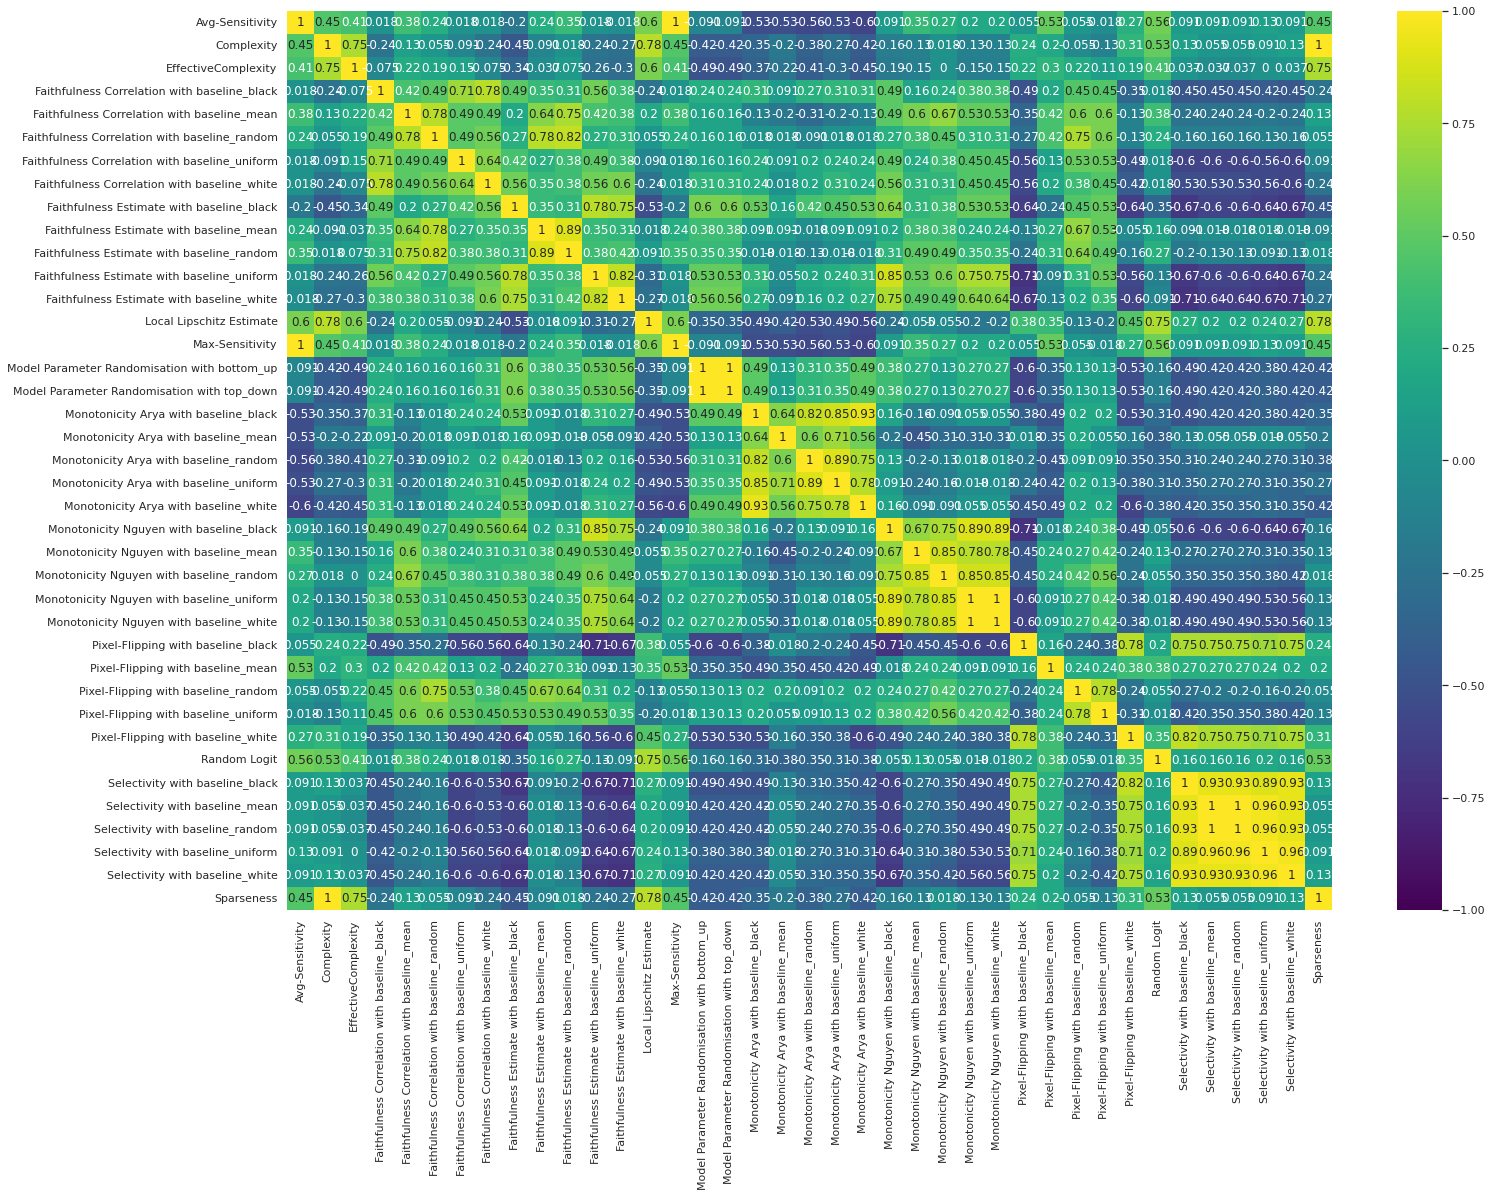

In [9]:
# Correlation Matrix
sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           cmap='viridis')
plt.show()

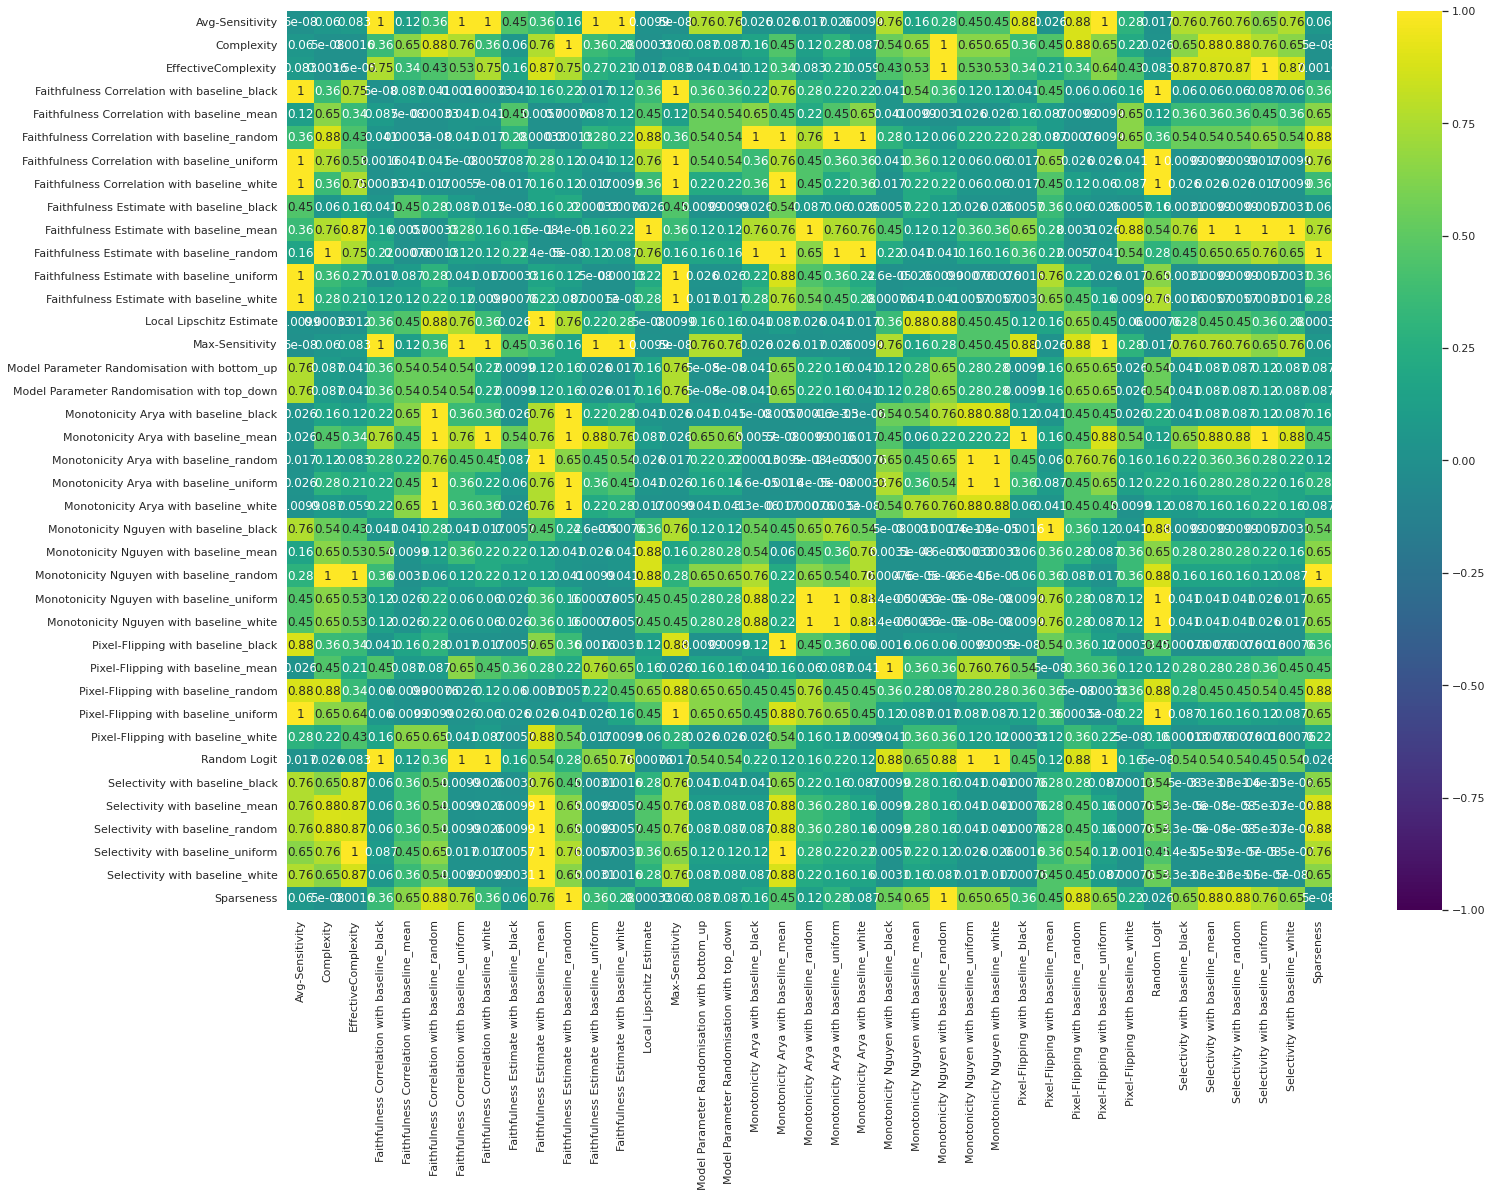

In [10]:
# Matrix of the p_values
sn.heatmap(p_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           cmap='viridis')
plt.show()

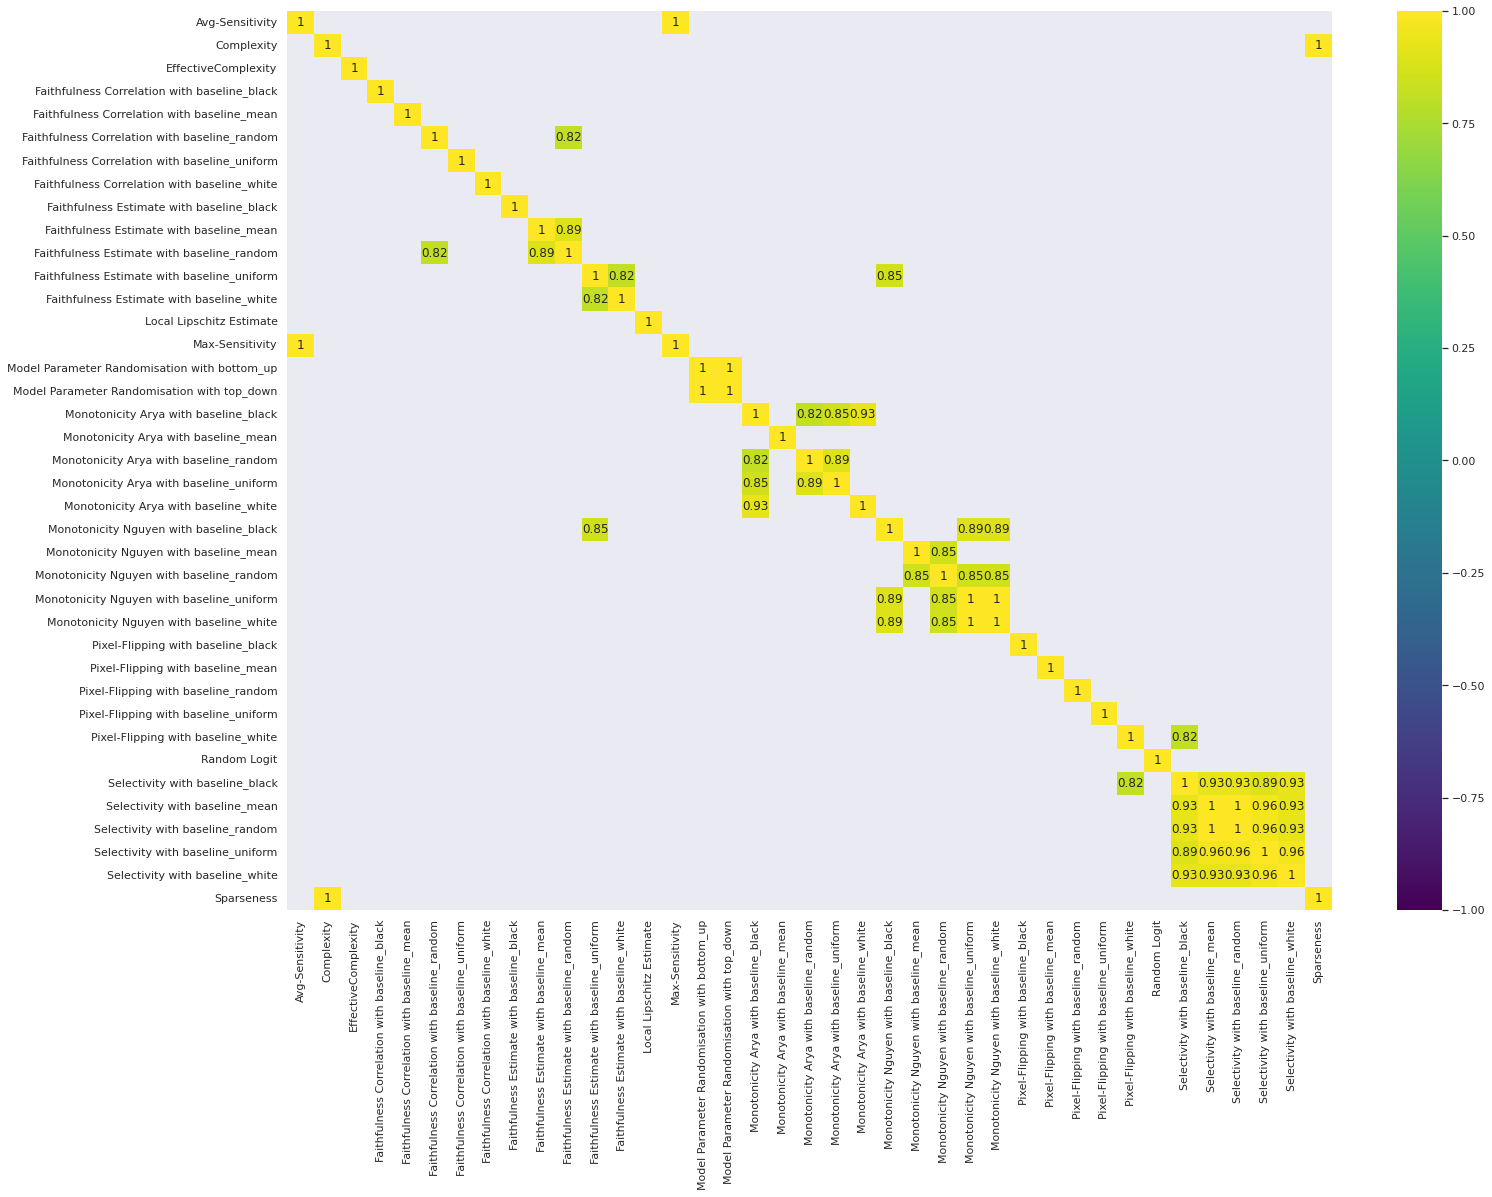

In [11]:
# Correlation Matrix with only significative values (Bonferroni Correction)
p_threshold = 0.05 / len(metrics) ** 2 
p_values_mask = []
for sublist in p_values:
    p_values_mask.append([p_value > p_threshold for p_value in sublist])
    
p_values_mask = np.array(p_values_mask)

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           mask=p_values_mask,
           cmap='viridis')
plt.savefig('./results/corr_matrix_rank_aggreg_bonferroni_corr.png')
plt.show()

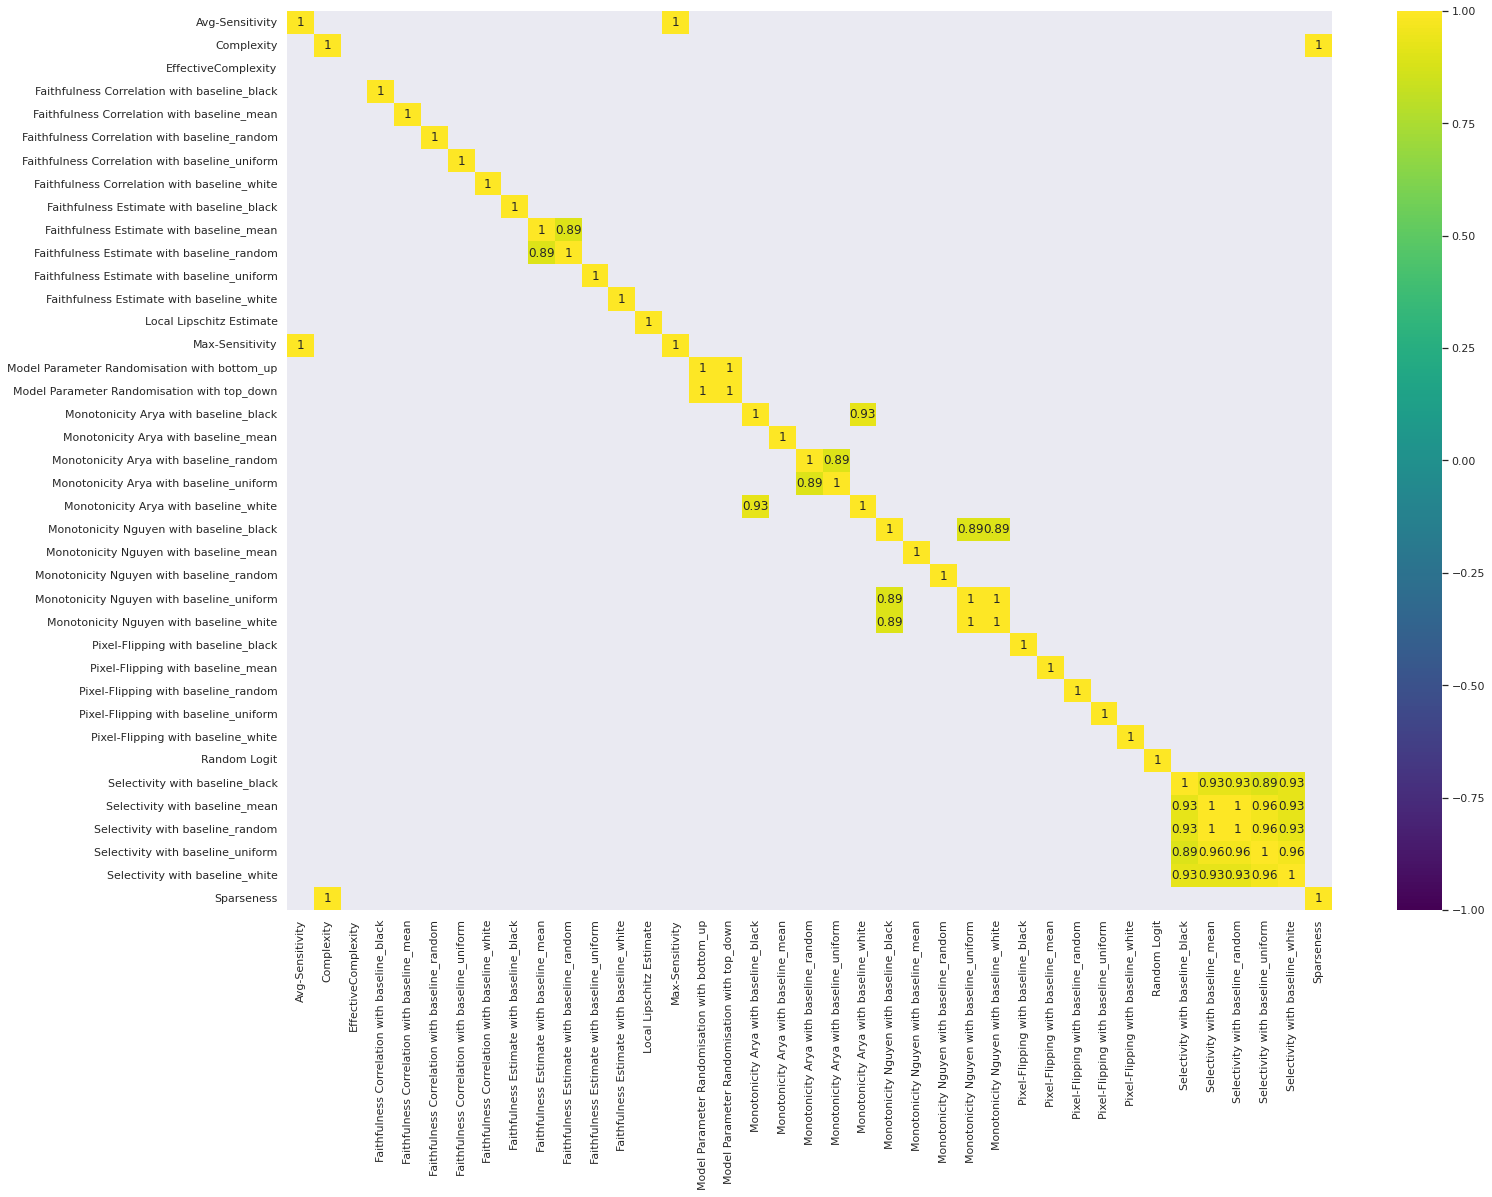

In [12]:
# Correlation Matrix with only significative values (Holm Correction)
from statsmodels.stats.multitest import multipletests

p_values_flattened = [p_value for sublist in p_values for p_value in sublist]
reject, pvals_corrected, _, alphacBonf = multipletests(p_values_flattened,
                                                       alpha=0.05,
                                                       method='holm')

sn.heatmap(tau_values,
           annot=True,
           vmin=-1,
           vmax=1,
           xticklabels=metrics_with_baselines,
           yticklabels=metrics_with_baselines,
           mask=np.invert(reject).reshape((len(metrics_with_baselines),len(metrics_with_baselines))),
           cmap='viridis')
plt.savefig('./results/corr_matrix_rank_aggreg_holm_corr.png')
plt.show()